1. Object Detection using YOLOv8
2. Install and Update Libraries
3. Project Objectives

3.1 Model Configurations
3.2 Reading Video with CV2
3.3 Capturing Video Information
3.4 Video Output
3.5 Executing Recognition
3.6 Post Processing
4. Sampling Transformed Frame Results
5. Executing Result Video
6. Conclusion

# **1. Object Detection using YOLOv8**

The You Only Look Once, or YOLO, family of models are a series of end-to-end deep learning models designed for fast object detection.

The approach involves a single deep convolutional neural network (originally a version of GoogLeNet, later updated and called DarkNet based on VGG) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification.

The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

This topic is a subject of active research and another version called YOLOv8 was developed in 2023.

# **2. Install and update libraries**

In [1]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 17.6 MB/s eta 0:00:00


In [2]:
# Object Detecion
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline

In [3]:
# Video path for experiment
path = '/content/road_trafifc.mp4'

In [4]:
# Displaying the target video
frac = 0.65
display(Video(data=path, height=int(720*frac), width=int(1280*frac)))

In [5]:
#loading a YOLO model
model = YOLO('yolov8x.pt')

#geting names from classes
dict_classes = model.model.names

100%|██████████| 131M/131M [00:00<00:00, 214MB/s]


In [17]:
model.model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [6]:
model.info(detailed=True)

layer                                     name  gradient   parameters                shape         mu      sigma
    0                      model.0.conv.weight     False         2160        [80, 3, 3, 3]  -0.000886     0.0835 torch.float32
    1                        model.0.bn.weight     False           80                 [80]       2.84       1.18 torch.float32
    2                          model.0.bn.bias     False           80                 [80]      0.131       1.58 torch.float32
    3                      model.1.conv.weight     False       115200      [160, 80, 3, 3]  -0.000435     0.0142 torch.float32
    4                        model.1.bn.weight     False          160                [160]       2.56      0.554 torch.float32
    5                          model.1.bn.bias     False          160                [160]      0.264       1.16 torch.float32
    6                  model.2.cv1.conv.weight     False        25600     [160, 160, 1, 1]   -0.00238     0.0221 torch.float3

(365, 68229648, 0, 258.5472512)

In [7]:
def resize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    if frame is None:
        return frame
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

In [8]:
### Configurations
#Verbose during prediction
verbose = False
# Scaling percentage of original frame
scale_percent = 50

In [18]:
# Reading video with cv2
video = cv2.VideoCapture(path)

# Objects to detect Yolo
class_IDS = [0, 1, 2, 3, 5, 7]
# Auxiliary variables
centers_old = {}
centers_new = {}
obj_id = 0
veiculos_contador_in = dict.fromkeys(class_IDS, 0)
veiculos_contador_out = dict.fromkeys(class_IDS, 0)
end = []
frames_list = []
cy_linha = int(1500 * scale_percent/100 )
cx_sentido = int(2000 * scale_percent/100)
offset = int(8 * scale_percent/100 )
contador_in = 0
contador_out = 0
print(f'[INFO] - Verbose during Prediction: {verbose}')


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (640, 360)
[INFO] - Scaling change may cause errors in pixels lines 
[INFO] - Dim Scaled:  (320, 180)


In [20]:
# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

[INFO] - Original Dim:  (640, 360)
[INFO] - Scaling change may cause errors in pixels lines 
[INFO] - Dim Scaled:  (320, 180)


In [21]:
#-------------------------------------------------------
### Video output ####
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path,
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                               fps, (width, height))

In [22]:
#-------------------------------------------------------
# Executing Recognition
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1)):

    # reading frame from video
    _, frame = video.read()

    #Applying resizing of read frame

    frame  = resize_frame(frame, scale_percent)

    if verbose:
        print('Dimension Scaled(frame): ', (frame.shape[1], frame.shape[0]))

    # Getting predictions
    y_hat = model.predict(frame, conf = 0.7, classes = class_IDS, device = 0, verbose = False)

    # Getting the bounding boxes, confidence and classes of the recognize objects in the current frame.
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy()

    # Storing the above information in a dataframe
    positions_frame = pd.DataFrame(y_hat[0].cpu().numpy().boxes.data, columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])

    #Translating the numeric class labels to text
    labels = [dict_classes[i] for i in classes]

    # Drawing transition line for in\out vehicles counting
    cv2.line(frame, (0, cy_linha), (int(4500 * scale_percent/100 ), cy_linha), (255,255,0),8)

    # For each vehicles, draw the bounding-box and counting each one the pass thought the transition line (in\out)
    for ix, row in enumerate(positions_frame.iterrows()):
        # Getting the coordinates of each vehicle (row)
        xmin, ymin, xmax, ymax, confidence, category,  = row[1].astype('int')

        # Calculating the center of the bounding-box
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)

        # drawing center and bounding-box of vehicle in the given frame
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 5) # box
        cv2.circle(frame, (center_x,center_y), 5,(255,0,0),-1) # center of box

        #Drawing above the bounding-box the name of class recognized.
        cv2.putText(img=frame, text=labels[ix]+' - '+str(np.round(conf[ix],2)),
                    org= (xmin,ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=2)

        # Checking if the center of recognized vehicle is in the area given by the transition line + offset and transition line - offset
        if (center_y < (cy_linha + offset)) and (center_y > (cy_linha - offset)):
            if  (center_x >= 0) and (center_x <=cx_sentido):
                contador_in +=1
                veiculos_contador_in[category] += 1
            else:
                contador_out += 1
                veiculos_contador_out[category] += 1

    #updating the counting type of vehicle
    contador_in_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_in.items()]
    contador_out_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_out.items()]

    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text='N. vehicles In',
                org= (30,30), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                fontScale=1, color=(255, 255, 0),thickness=1)

    cv2.putText(img=frame, text='N. vehicles Out',
                org= (int(2800 * scale_percent/100 ),30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=1)

    #drawing the counting of type of vehicles in the corners of frame
    xt = 40
    for txt in range(len(contador_in_plt)):
        xt +=30
        cv2.putText(img=frame, text=contador_in_plt[txt],
                    org= (30,xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=1, color=(255, 255, 0),thickness=1)

        cv2.putText(img=frame, text=contador_out_plt[txt],
                    org= (int(2800 * scale_percent/100 ),xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=1, color=(255, 255, 0),thickness=1)

    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text=f'In:{contador_in}',
                org= (int(1820 * scale_percent/100 ),cy_linha+60),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)

    cv2.putText(img=frame, text=f'Out:{contador_out}',
                org= (int(1800 * scale_percent/100 ),cy_linha-40),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)

    if verbose:
        print(contador_in, contador_out)
    #Saving frames in a list
    frames_list.append(frame)
    #saving transformed frames in a output video formaat
    output_video.write(frame)

#Releasing the video
output_video.release()

  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
####  pos processing
# Fixing video output codec to run in the notebook\browser
if os.path.exists(output_path):
    os.remove(output_path)

subprocess.run(
    ["ffmpeg",  "-i", tmp_output_path,"-crf","18","-preset","veryfast","-hide_banner","-loglevel","error","-vcodec","libx264",output_path])
os.remove(tmp_output_path)

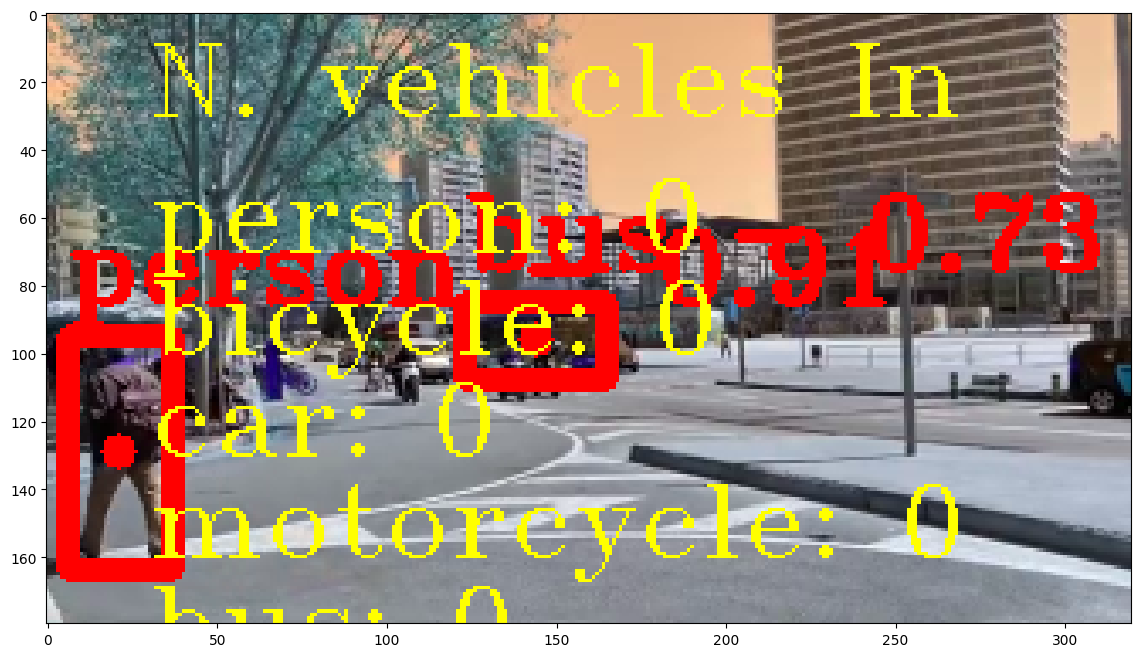

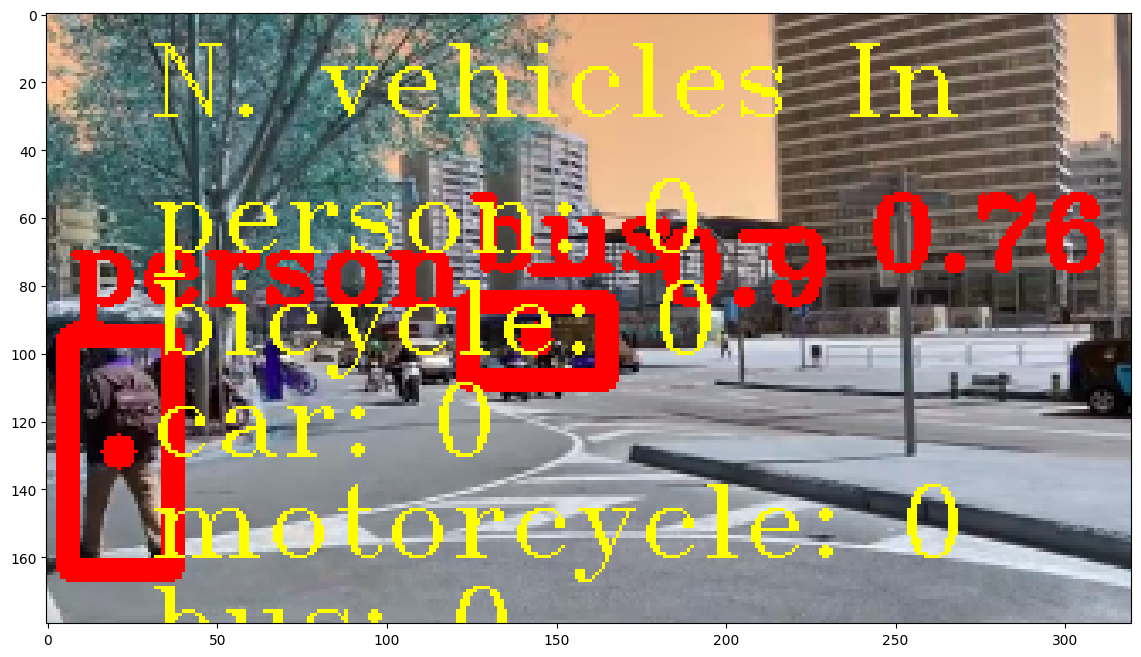

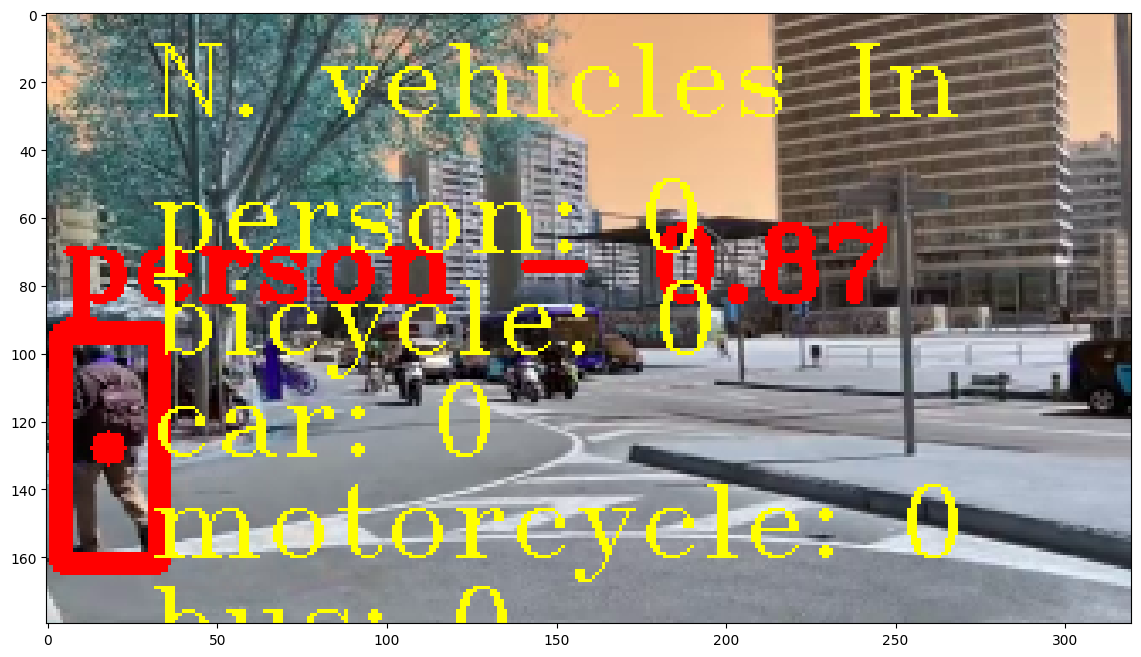

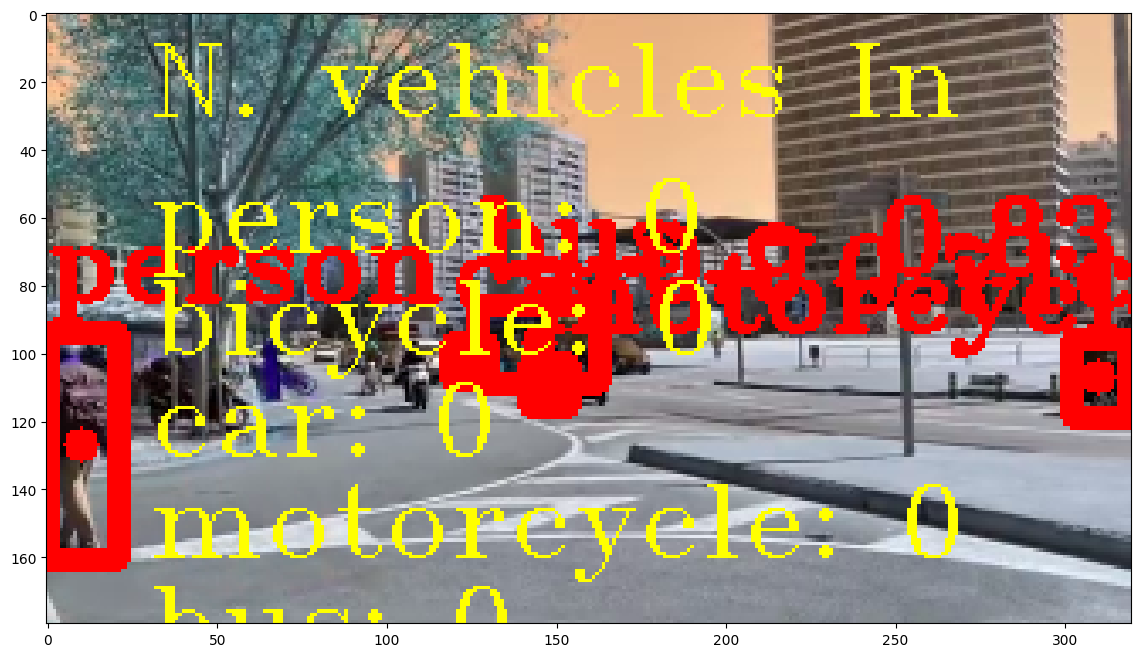

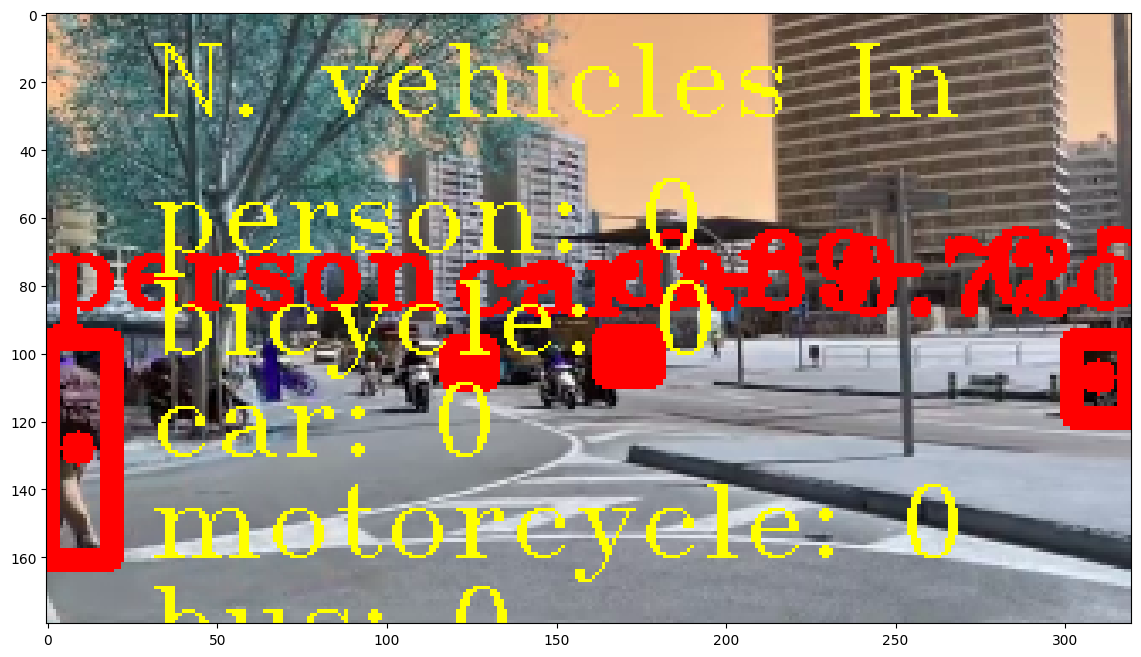

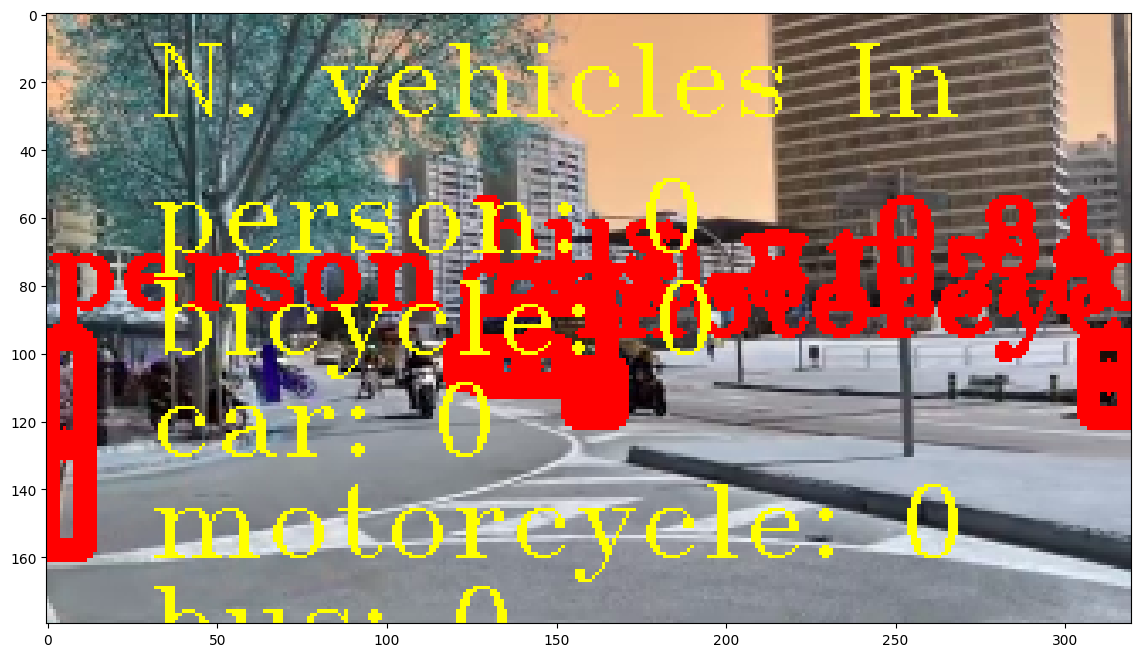

In [24]:
# Checking samples of processed frames
for i in [28, 29, 32, 40, 42, 50]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()

In [25]:
#output video result
frac = 0.7
Video(data='rep_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))